# Selección de variables con Information Value (IV)

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## Importación de los datos

In [2]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
import pandas as pd

def metricas_modelos(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print "La matriz de confusión es "
    print confusion_matrix

    print 'Precisión:', accuracy_score(y_true, y_pred)
    print 'Exactitud:', precision_score(y_true, y_pred)
    print 'Exhaustividad:', recall_score(y_true, y_pred)
    print 'F1:', f1_score(y_true, y_pred)

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print 'AUC:', auc(false_positive_rate, recall)

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title('AUC = %0.2f' % roc_auc)

# Importación de los datos
credit_approval = pd.read_csv('crx_data.txt', sep = ',')
credit_approval.head()
mask = credit_approval.applymap(lambda x: x in ['?'])
credit_not_null = credit_approval[-mask.any(axis=1)]

# Separación de las variables
var_categoricas = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A11', 'A12', 'A13']
var_numericas   = ['A2', 'A3', 'A8', 'A14', 'A15']
var_target      = credit_not_null['A16'] == '+'

## Information Value

Se procede a la estimación del IV utilizando la expresión:
$$
    IV =  \sum_{i = 1}^{N} (R_i(T) - R_i(F)) \ln \left| \frac{R_i(T)}{R_i(F)} \right|
$$

In [3]:
from sklearn.linear_model.logistic import LogisticRegression

result_IV = []

for v_cat in var_categoricas:
    var_target = array(var_target)
    var_values = array(credit_not_null[v_cat])
    var_levels = unique(var_values)

    mat_values = numpy.zeros(shape=(len(var_levels),2))

    for i in range(len(var_target)):
        # Obtención de la posición en los niveles del valor
        for j in range(len(var_levels)):
            if var_levels[j] == var_values[i]:
                pos = j
                break

        # Estimación del número valores en cada nivel
        if var_target[i]:
            mat_values[pos][0] += 1
        else:
            mat_values[pos][1] += 1

        # Obtención del IV
        IV = 0
        for j in range(len(var_levels)):
            if mat_values[j][0] > 0 and mat_values[j][1] > 0:
                rt = mat_values[j][0] / (mat_values[j][0] + mat_values[j][1])
                rf = mat_values[j][1] / (mat_values[j][0] + mat_values[j][1])
                IV += (rt - rf) * np.log(rt / rf)
        
    # Se agrega el IV al listado
    result_IV.append(IV)

for i in range(len(var_categoricas)):
    print "La variable", var_categoricas[i], "el IV es", result_IV[i]

La variable A1 el IV es 0.0310557839282
La variable A4 el IV es 0.353312725336
La variable A5 el IV es 0.353312725336
La variable A6 el IV es 5.30149147134
La variable A7 el IV es 2.34839349885
La variable A9 el IV es 3.24769074169
La variable A10 el IV es 0.895478013341
La variable A11 el IV es 11.0569990916
La variable A12 el IV es 0.0423925791404
La variable A13 el IV es 0.411470398153


Las únicas variables que no permiten separar la variable objetivo por encima de la media son `A1` y `A12`. Por otro lado, las que muestran una relación fuertes (> 0,5) son las `A6`, `A7`, `A9`, `A10` y `A11`

La matriz de confusión es 
[[297  24]
 [ 60 272]]
Precisión: 0.871362940276
Exactitud: 0.918918918919
Exhaustividad: 0.819277108434
F1: 0.866242038217
AUC: 0.872255376647


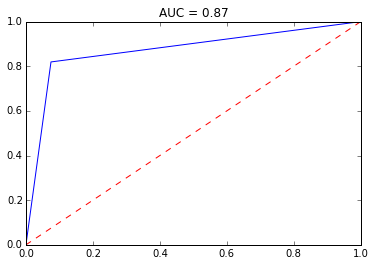

In [4]:
data_model = concatenate((pd.get_dummies(credit_not_null['A6']),
                          pd.get_dummies(credit_not_null['A7']),
                          pd.get_dummies(credit_not_null['A9']),
                          pd.get_dummies(credit_not_null['A10']),
                          pd.get_dummies(credit_not_null['A11'])), axis = 1)

classifier = LogisticRegression().fit(data_model, var_target)
y_pred     = classifier.predict(data_model)

metricas_modelos(y_pred, var_target)